In [75]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection
import plotly.figure_factory as ff
from IPython.display import HTML, display
from IPython.core import display as ICD
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import Artificial_Neural_Networks as ANN
import ARIMA

import math
from itertools import groupby
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from importlib import reload
import itertools
import warnings
warnings.filterwarnings('ignore')

In [91]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

def correlation_coefficient(y_true, y_pred):
    y_true = np.array(y_true)
    y_true = np.reshape(y_true, (y_true.shape[0],))
    y_pred = np.array(y_pred)
    print(y_true, y_true.shape)
    print(y_pred, y_pred.shape)
    corr_coef = np.corrcoef(y_true, y_pred)[0, 1]
    return corr_coef

def calculate_performance(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    corr_coef = correlation_coefficient(y_true, y_pred)
    return round(mse, 3), round(mae, 3), round(mape, 3), round(rmse, 3), round(corr_coef, 3)

## Preprocess data

In [40]:
PATH = 'rainfall_data_1901_to_2002.xlsx'

In [41]:
data = pd.read_excel(PATH)

In [42]:
data = data.drop(columns='vlookup')
data = data[data['Year'].notnull()]
data['Year'] = data.Year.astype('int')
data.index = range(len(data))
data.head()

,State,District,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,Andhra Pradesh,Adilabad,1901,6.725,10.488,23.288,35.560,23.119,115.546,294.119,276.865,181.615,47.310,1.339,0.000
1,Andhra Pradesh,Adilabad,1902,0.420,0.000,0.388,6.070,3.331,45.960,233.973,167.971,198.177,26.447,35.083,11.222
2,Andhra Pradesh,Adilabad,1903,6.643,1.956,0.173,4.551,33.348,132.078,436.611,334.544,226.037,138.818,14.095,8.823
3,Andhra Pradesh,Adilabad,1904,0.054,0.121,11.446,0.017,16.900,131.048,160.694,81.865,251.577,110.391,0.146,0.130
4,Andhra Pradesh,Adilabad,1905,0.589,2.293,8.252,35.020,17.569,79.937,96.331,313.522,361.697,4.950,0.146,0.000


In [43]:
m_data = data[data['State'] == 'Maharashtra']
m_data = m_data.drop(columns='State')
m_data.head()

,District,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
26826,Ahmadnagar,1901,2.510,11.489,11.325,33.931,30.401,262.971,162.397,120.152,58.708,62.633,0.596,0.000
26827,Ahmadnagar,1902,0.603,0.000,0.003,1.340,6.338,90.293,223.483,101.852,297.212,61.453,41.992,26.715
26828,Ahmadnagar,1903,0.227,0.000,0.000,2.602,69.076,182.652,500.983,156.236,164.433,88.419,2.022,3.999
26829,Ahmadnagar,1904,0.937,1.126,1.051,2.378,4.365,120.658,117.058,38.470,225.726,72.389,0.271,0.000
26830,Ahmadnagar,1905,0.000,0.622,0.000,0.452,4.115,114.385,197.696,116.061,54.338,66.508,6.581,0.000


In [44]:
# import matplotlib.pyplot as plt
# import pandas as pd
# from pandas.tools.plotting import table

# plt.figure(figsize=(15,5))
# ax = plt.subplot(111, frame_on=False) # no visible frame
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis

# table(ax, m_data.head(20))  # where df is your data frame

# plt.savefig('Maharashtra_data.png')

In [45]:
districts = m_data.District.unique()
years = list(range(1901, 2003))
months = data.columns[3:]
year_month = [str(year) + '_' + month for year in years for month in months]
dates = pd.date_range(start='1901-01', freq='MS', periods=len(years)*12)

In [46]:
maharashtra_data = pd.DataFrame({'Year_Month': year_month})
maharashtra_data['Date'] = dates
maharashtra_data[['Year', 'Month']] = maharashtra_data['Year_Month'].str.split('_', n=1, expand=True)
maharashtra_data = maharashtra_data.drop(columns=['Year_Month'])

for district in districts:
    df = m_data[m_data.District == district].drop(columns=['District', 'Year'])
    df = df.as_matrix().reshape((len(years) * len(months), 1))[:,0]
    maharashtra_data[district] = df

#maharashtra_data = maharashtra_data.rename(columns={'Gadchiroli': 'Garhchiroli'})
maharashtra_data.head()

,Date,Year,Month,Ahmadnagar,Akola,Amravati,Aurangabad,Bhandara,Bid,Buldana,...,Nashik,Osmanabad,Parbhani,Pune,Sangli,Satara,Solapur,Wardha,Washim,Yavatmal
0,1901-01-01,1901,Jan,2.510,34.202,35.651,10.922,23.397,16.647,31.455,...,5.063,15.500,33.207,0.922,0.138,0.197,4.496,45.050,32.485,22.031
1,1901-02-01,1901,Feb,11.489,1.099,6.822,4.362,63.844,1.916,0.823,...,1.609,2.784,4.997,7.195,0.537,0.525,3.667,28.220,3.607,16.198
2,1901-03-01,1901,Mar,11.325,30.002,36.103,25.161,33.563,27.287,28.448,...,11.196,11.333,31.625,5.105,13.090,9.566,10.330,26.398,26.557,29.318
3,1901-04-01,1901,Apr,33.931,10.248,10.636,12.714,61.560,33.211,13.902,...,7.838,34.814,41.941,35.949,50.077,30.110,59.854,29.228,18.127,30.521
4,1901-05-01,1901,May,30.401,2.891,4.173,34.244,13.665,59.027,9.397,...,7.475,52.792,31.794,36.650,78.994,65.226,50.892,8.619,6.700,13.193


## Correlation matrix - Districts

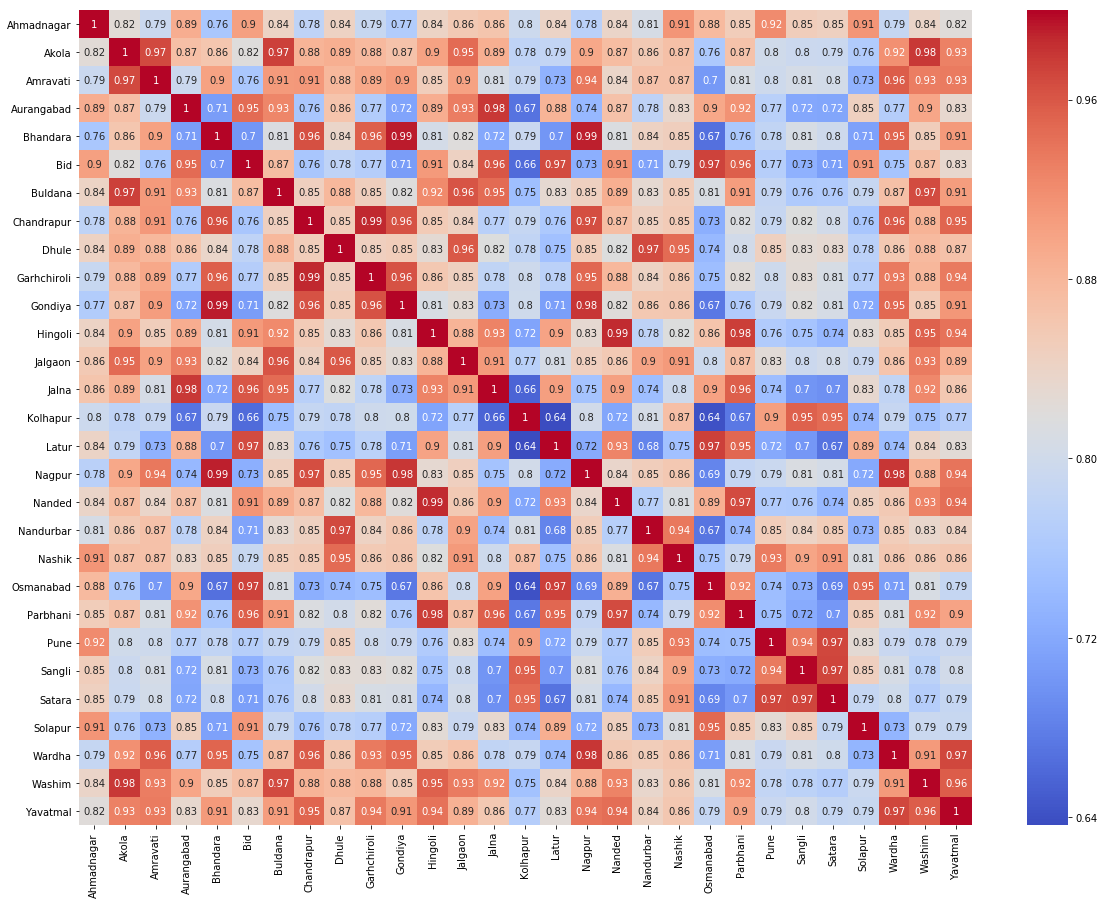

In [47]:
corr_matrix = maharashtra_data.drop(columns=['Year', 'Month']).corr().abs()
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

## Highly correlated districts

In [48]:
def return_highly_correlated(corr_matrix, corr_coef):
    district_corr = corr_matrix.abs().unstack().sort_values().drop_duplicates()
    tuples = district_corr[(district_corr > corr_coef) & (district_corr != 1.0)]
    levels = tuples.index.levels[0]
    labels = tuples.index.labels

    high_corr_districts = []
    for i in range(len(labels[0])):
        high_corr_districts.append([levels[labels[0][i]], levels[labels[1][i]], tuples[i]])
    high_corr_districts = np.array(high_corr_districts)
    df = pd.DataFrame({'District1': high_corr_districts[:, 0], 
                      'District2': high_corr_districts[:, 1],
                      'Correlation_coefficient': high_corr_districts[:, 2]},
                     columns = ['District1', 'District2', 'Correlation_coefficient'])
    return df

In [49]:
high_corr_districts = return_highly_correlated(corr_matrix, 0.98)
high_corr_districts

,District1,District2,Correlation_coefficient
0,Nagpur,Gondiya,0.9805330709528167
1,Nagpur,Wardha,0.9811563634226902
2,Nanded,Hingoli,0.9858166679818119
3,Chandrapur,Garhchiroli,0.9885737788804028
4,Nagpur,Bhandara,0.9907760645844106
5,Bhandara,Gondiya,0.9922307205938624


### Highly correlated districts - Map

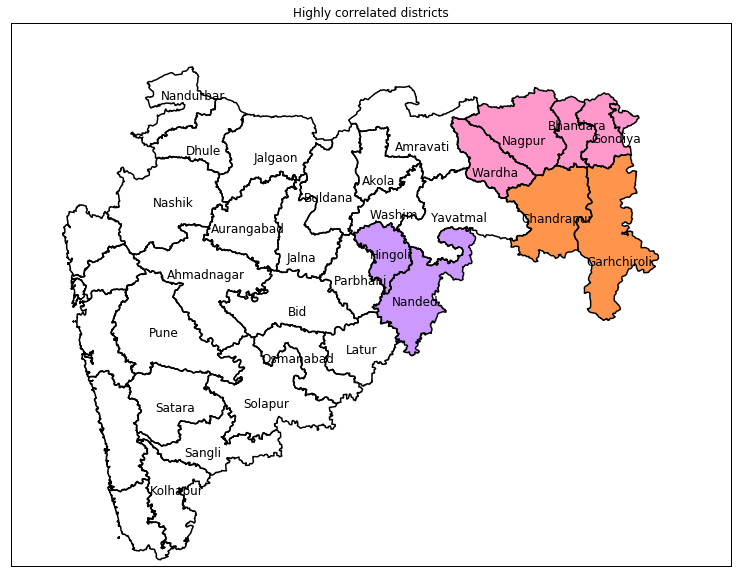

In [50]:
correlated_districts = [['Nagpur', 'Gondiya', 'Wardha', 'Bhandara'], ['Nanded', 'Hingoli'], ['Chandrapur', 'Garhchiroli']]
correlated_districts_dict = {}
bin_num = 0
for l in correlated_districts:
    for dist in l:
        correlated_districts_dict[dist]=bin_num
    bin_num+=1

latlon_data = pd.read_csv("district_latlon.csv") 
latlon_data = latlon_data.drop(latlon_data.columns[latlon_data.columns.str.contains('unnamed',case = False)],axis = 1)

num_colors = len(correlated_districts)
cm = plt.get_cmap('rainbow')
correlated_districts_df = pd.DataFrame({'Method': list(correlated_districts_dict.values())})
correlated_districts_df.index = correlated_districts_dict.keys()
correlated_districts_df['bin'] = correlated_districts_dict.values()
scheme = ['#ff99cc', '#cc99ff', '#ff944d']
# scheme = [cm(i / num_colors) for i in range(num_colors)]
values = correlated_districts_df.bin
#bins = np.linspace(values.min(), values.max(), num_colors)

fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111, frame_on=False)

map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
               llcrnrlat=15.5,urcrnrlon=82,urcrnrlat=22.5,lat_0=16,lon_0=75.11)
map.drawmapboundary(fill_color='white')
map.fillcontinents(color='white',lake_color='white')
map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)

patches   = []
facecolor_array = []
for info, shape in zip(map.gadm36_IND_2_info, map.gadm36_IND_2):
    if(info['NAME_1'] == 'Maharashtra'):
        x, y = zip(*shape) 
        map.plot(x, y, marker='', color='black')
        district = info['NAME_2']
        if district not in correlated_districts_df.index:
            color = '#dddddd'
        else:
            color = scheme[correlated_districts_df.ix[district]['bin']]
            patches.append( Polygon(np.array(shape), True))
            facecolor_array.append(color)
    else:
        color = '#dddddd'

ax.add_collection(PatchCollection(patches, facecolor= facecolor_array, edgecolor='w', linewidths=1., zorder=2))
ax.set_title("Highly correlated districts")

lat = latlon_data['lat'].tolist()
lon = latlon_data['lon'].tolist()
label_dist = latlon_data['district'].tolist()

X,Y = map(lon,lat)
ax.scatter(X,Y)
for i, (x, y) in enumerate(zip(X, Y), start=0):
    district_name = label_dist[i]
    ax.annotate(district_name, (x,y), xytext=(0,0), textcoords='offset points',fontsize=12,color='black')
plt.show()

### Rainfall for the district "Kolhapur"

Text(0.5,1,'Rainfall of Kolhapur district')

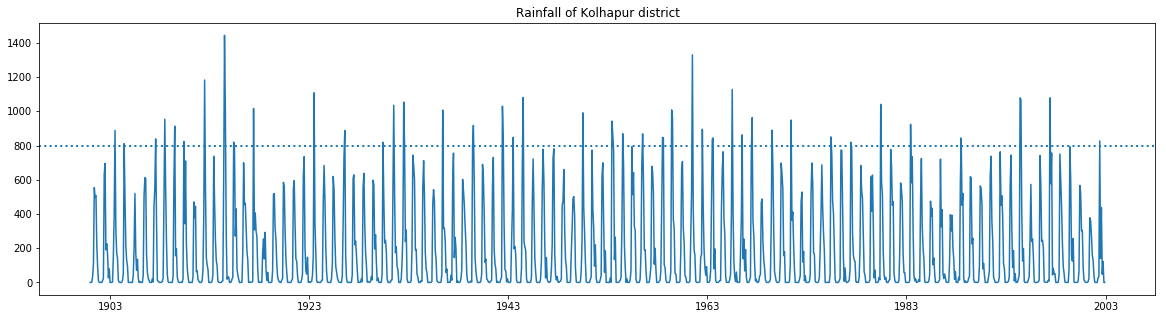

In [51]:
plt.figure(figsize=(20,5))
plt.plot(maharashtra_data.Date, maharashtra_data.Kolhapur)
plt.axhline(y=800, linewidth=2, linestyle='dotted')
plt.title('Rainfall of Kolhapur district')

In [52]:
maharashtra_data[maharashtra_data.Month == 'Jul'].Kolhapur.mean()

676.4755490196079

## Plot the districts with heavy rainfall over all years(>700|800mm)

In [53]:
high_rainfall = {}
high_rainfall_months = {}
districts = maharashtra_data.columns[3:]
for district in districts:
    count = len(maharashtra_data[maharashtra_data[district]>=800])
    if count != 0:
#         print(district)
#         print(maharashtra_data[maharashtra_data[district]>=800].head(40))
        high_rainfall[district] = count
        high_rainfall_months[district] = list(maharashtra_data[maharashtra_data[district]>=800].Month)
        
for district in high_rainfall_months:
    print(district)
    counts = [(i, len(list(c))) for i,c in groupby(sorted(high_rainfall_months[district]))] 
    print(counts)
high_rainfall

Pune
[('Jul', 2), ('Jun', 1)]
Satara
[('Jul', 20), ('Jun', 5)]
Nandurbar
[('Jul', 10)]
Sangli
[('Jul', 1)]
Kolhapur
[('Aug', 5), ('Jul', 27), ('Jun', 17)]
Nashik
[('Jul', 1)]


{'Kolhapur': 49,
 'Nandurbar': 10,
 'Nashik': 1,
 'Pune': 3,
 'Sangli': 1,
 'Satara': 25}

           Count  bin
Pune           3    0
Satara        25    0
Nandurbar     10    0
Sangli         1    0
Kolhapur      49    0
Nashik         1    0


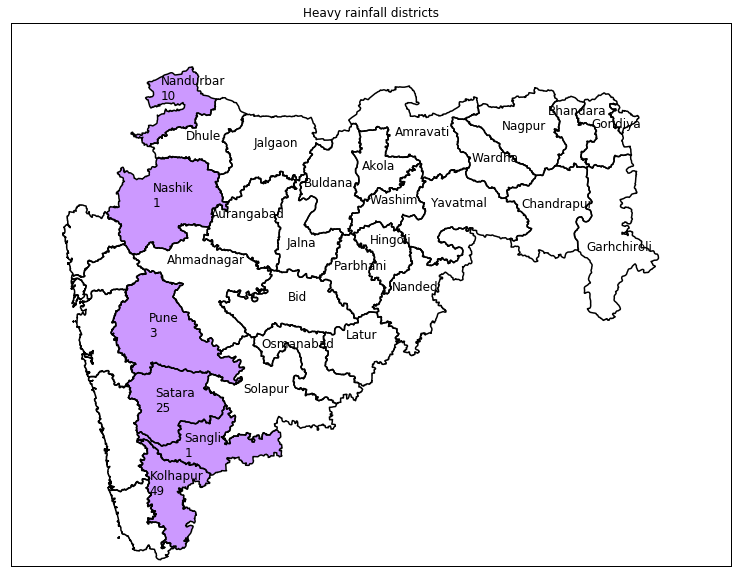

In [54]:
latlon_data = pd.read_csv("district_latlon.csv") 
latlon_data = latlon_data.drop(latlon_data.columns[latlon_data.columns.str.contains('unnamed',case = False)],axis = 1)

num_colors = 1
cm = plt.get_cmap('rainbow')
high_rainfall_df = pd.DataFrame({'Count': list(high_rainfall.values())})
high_rainfall_df.index = high_rainfall.keys()
high_rainfall_df['bin'] = 0
#scheme = ['#ff99cc', '#cc99ff', '#ff944d']
scheme = ['#cc99ff']
values = high_rainfall_df.bin
print(high_rainfall_df)

fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111, frame_on=False)

map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
               llcrnrlat=15.5,urcrnrlon=82,urcrnrlat=22.5,lat_0=16,lon_0=75.11)
map.drawmapboundary(fill_color='white')
map.fillcontinents(color='white',lake_color='white')
map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)

patches   = []
facecolor_array = []
for info, shape in zip(map.gadm36_IND_2_info, map.gadm36_IND_2):
    if(info['NAME_1'] == 'Maharashtra'):
        x, y = zip(*shape) 
        map.plot(x, y, marker='', color='black')
        district = info['NAME_2']
        if district not in high_rainfall_df.index:
            color = '#dddddd'
        else:
            color = scheme[high_rainfall_df.ix[district]['bin']]
            patches.append( Polygon(np.array(shape), True))
            facecolor_array.append(color)
    else:
        color = '#dddddd'

ax.add_collection(PatchCollection(patches, facecolor= facecolor_array, edgecolor='w', linewidths=1., zorder=2))
ax.set_title("Heavy rainfall districts")

lat = latlon_data['lat'].tolist()
lon = latlon_data['lon'].tolist()
label_dist = latlon_data['district'].tolist()

X,Y = map(lon,lat)
ax.scatter(X,Y)
for i, (x, y) in enumerate(zip(X, Y), start=0):
    district_name = label_dist[i]
    try:
        ax.annotate(district_name + "\n" + str(high_rainfall_df.ix[district_name].Count), (x,y), xytext=(0,0), textcoords='offset points', fontsize=12, color='black')
    except:
        ax.annotate(district_name + "\n", (x,y), xytext=(0,0), textcoords='offset points', fontsize=12, color='black')
plt.show()

## Boxplot - District wise precipitation across all years

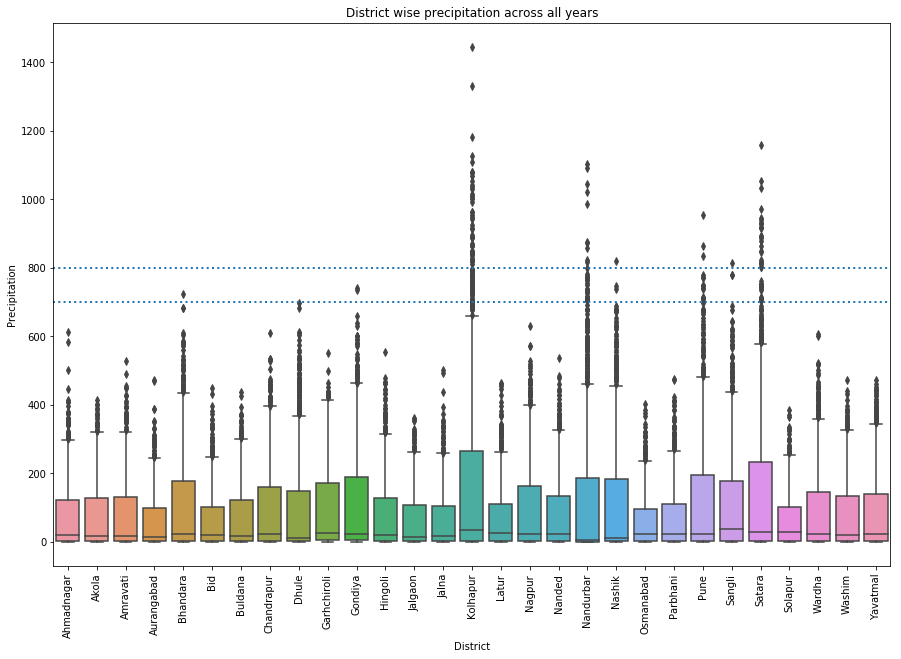

In [55]:
matrix = maharashtra_data.drop(columns=['Date', 'Year', 'Month'])

plt.figure(figsize=(15,10))
g = sns.boxplot(x="variable", y="value", data=pd.melt(matrix))
labels = g.get_xticklabels()
g.set_xticklabels(labels, rotation=90)
g.set_xlabel('District')
g.set_ylabel('Precipitation')
g.set_title('District wise precipitation across all years')
plt.axhline(y=700, linewidth=2, linestyle='dotted')
plt.axhline(y=800, linewidth=2, linestyle='dotted')

- In district 'Kolhapur', the precipitation is above 800mm for many times. It says that the rainfall was heavy in Kolhapur district.

## Yearly average precipitation data across all districts in Maharashtra

In [56]:
m_data_copy = maharashtra_data.copy()
m_data_copy = m_data_copy.drop(columns=['Date', 'Year', 'Month'])
m_data_copy = m_data_copy.groupby(np.arange(len(df))//12).mean()
columns = m_data_copy.columns
columns = columns.insert(0, 'Year')
m_data_copy['Year'] = maharashtra_data.Year.unique()
m_data_copy = m_data_copy.reindex(columns=columns)
m_data_copy.set_index('Year', inplace=True)

In [57]:
m_data_copy.head()

,Ahmadnagar,Akola,Amravati,Aurangabad,Bhandara,Bid,Buldana,Chandrapur,Dhule,Garhchiroli,...,Nashik,Osmanabad,Parbhani,Pune,Sangli,Satara,Solapur,Wardha,Washim,Yavatmal
Year,,,,,,,,,,,,,,,,,,,,,
1901,63.092750,77.823333,73.880833,62.966417,89.942500,68.990750,82.473833,92.038500,65.832667,82.867167,...,82.748167,56.653750,72.188500,111.361167,93.724583,131.658083,55.418750,85.357167,76.065333,82.455833
1902,70.940333,59.357500,61.660417,57.995167,67.120917,58.366167,56.106333,63.641167,93.626833,64.669333,...,108.657333,54.276250,59.543417,105.194917,93.180500,127.642583,52.421833,67.705750,62.795333,64.140083
1903,97.554083,78.115750,78.562250,65.851333,131.699667,74.999000,75.238000,112.471250,121.145583,113.153167,...,125.389917,87.275417,86.754917,127.237417,116.895250,130.759500,85.031583,97.724917,89.132250,101.637750
1904,48.702417,58.301917,48.570083,60.179417,77.639417,57.015417,64.512667,66.476000,65.572833,71.484583,...,77.788500,50.810000,60.305917,59.527833,69.020917,80.311583,43.898083,59.393333,65.820500,61.974667
1905,46.729833,56.520417,66.528167,37.807083,115.219833,36.920667,54.126833,93.275583,66.059417,95.537417,...,74.322667,38.655583,45.336000,95.595917,69.095750,111.762833,37.047167,83.216500,54.317333,69.244500


## Monthly rainfall for each year in Maharashtra

In [58]:
m_data_copy = m_data.copy()
m_data_copy['Jan-Feb'] = m_data_copy['Jan'] + m_data_copy['Feb']
m_data_copy['Mar-May'] = m_data_copy['Mar'] + m_data_copy['Apr'] + m_data_copy['May']
m_data_copy['Jun-Sep'] = m_data_copy['Jun'] + m_data_copy['Jul'] + m_data_copy['Aug'] + m_data_copy['Sep']
m_data_copy['Oct-Dec'] = m_data_copy['Oct'] + m_data_copy['Nov'] + m_data_copy['Dec']
m_data_copy['Annual'] = m_data_copy['Jan-Feb'] + m_data_copy['Mar-May'] + m_data_copy['Jun-Sep'] + m_data_copy['Oct-Dec']
m_data_copy.head()

,District,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec,Annual
26826,Ahmadnagar,1901,2.510,11.489,11.325,33.931,30.401,262.971,162.397,120.152,58.708,62.633,0.596,0.000,13.999,75.657,604.228,63.229,757.113
26827,Ahmadnagar,1902,0.603,0.000,0.003,1.340,6.338,90.293,223.483,101.852,297.212,61.453,41.992,26.715,0.603,7.681,712.840,130.160,851.284
26828,Ahmadnagar,1903,0.227,0.000,0.000,2.602,69.076,182.652,500.983,156.236,164.433,88.419,2.022,3.999,0.227,71.678,1004.304,94.440,1170.649
26829,Ahmadnagar,1904,0.937,1.126,1.051,2.378,4.365,120.658,117.058,38.470,225.726,72.389,0.271,0.000,2.063,7.794,501.912,72.660,584.429
26830,Ahmadnagar,1905,0.000,0.622,0.000,0.452,4.115,114.385,197.696,116.061,54.338,66.508,6.581,0.000,0.622,4.567,482.480,73.089,560.758


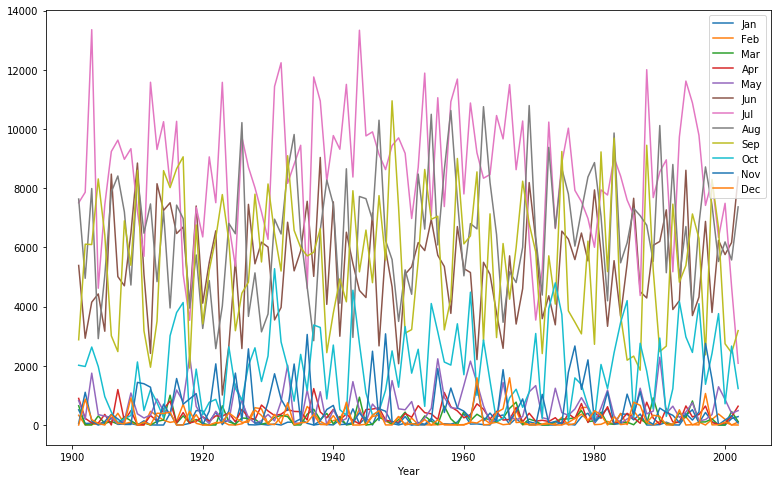

In [59]:
months = list(m_data.columns[1:])
m_data_copy[months].groupby("Year").sum().plot(figsize=(13,8))

## Seasonal rainfall for each year in Maharashtra

In [60]:
seasonal_data = m_data_copy[['Year','Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec']].groupby("Year").sum()

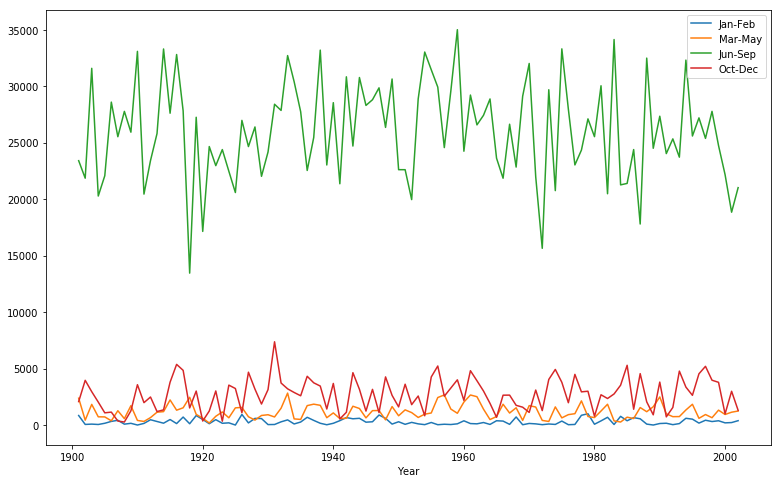

In [61]:
seasonal_data.plot(figsize=(13,8))

## District wise Seasonal rainfall across all years

In [62]:
seasonal_district_data = m_data_copy[['District','Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec']].groupby("District").sum()
seasonal_district_data.head()

,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
District,,,,
Ahmadnagar,249.735,4052.170,72472.375,9793.123
Akola,1396.348,2430.082,71598.467,9373.896
Amravati,1570.125,2631.008,76188.207,8760.707
Aurangabad,374.951,3030.083,56120.789,9403.228
Bhandara,3109.308,4954.334,111808.461,7086.156


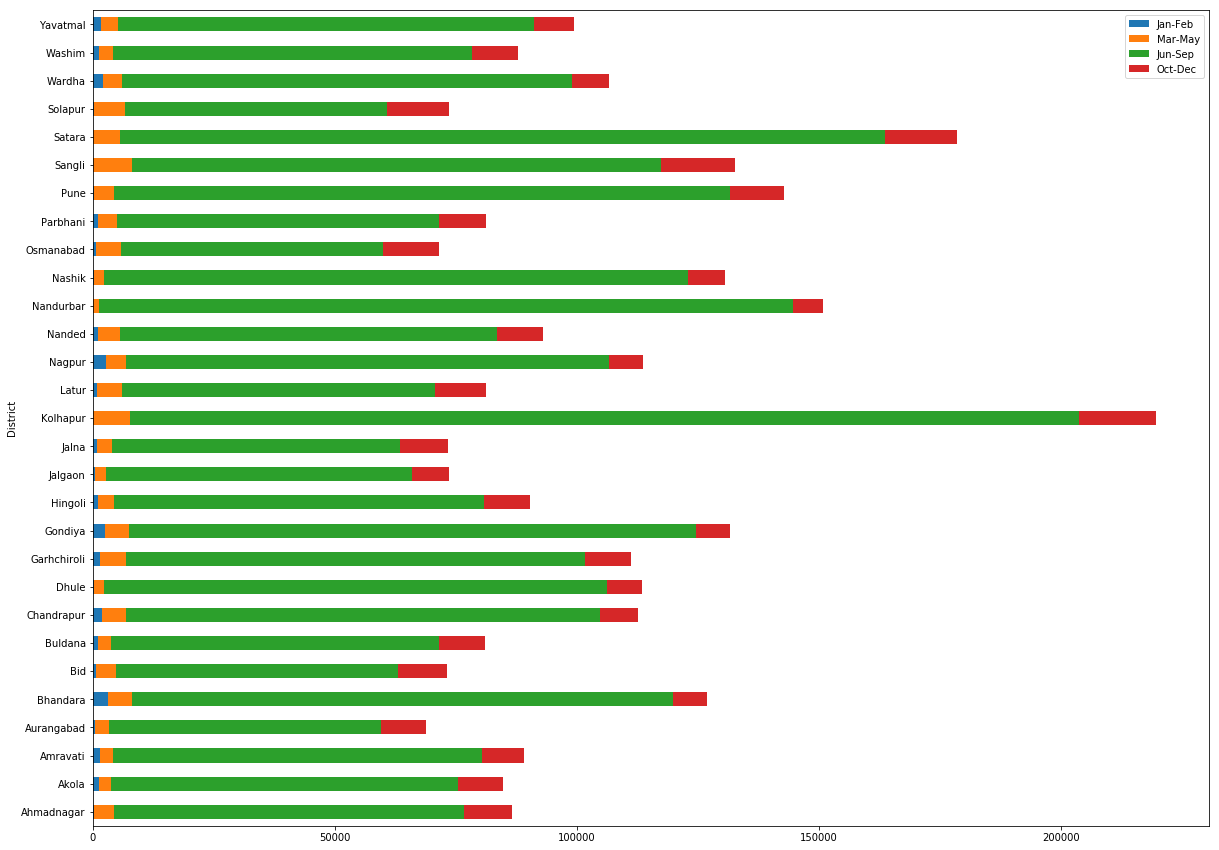

In [63]:
seasonal_district_data.plot.barh(stacked=True,figsize=(20,15));

## District wise Monthly mean precipitation across all years

In [64]:
columns = list(m_data.columns[2:])
columns.insert(0, m_data.columns[0])
monthly_mean_data = m_data_copy[columns].groupby("District").sum()
monthly_mean_data.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
District,,,,,,,,,,,,
Ahmadnagar,78.006,171.729,256.647,1109.044,2686.479,16877.414,23771.109,14935.436,16888.416,6820.429,2419.147,553.547
Akola,846.253,550.095,837.986,538.873,1053.223,14974.147,22112.462,18723.158,15788.700,5962.797,2420.409,990.690
Amravati,929.664,640.461,1131.693,575.061,924.254,14834.273,25561.345,20946.533,14846.056,5463.461,2313.593,983.653
Aurangabad,235.425,139.526,333.881,627.979,2068.223,11409.454,15241.871,10719.013,18750.451,5451.250,3068.053,883.925
Bhandara,1105.281,2004.027,1558.051,1794.416,1601.867,18865.044,38140.454,34557.667,20245.296,5127.286,1009.919,948.951


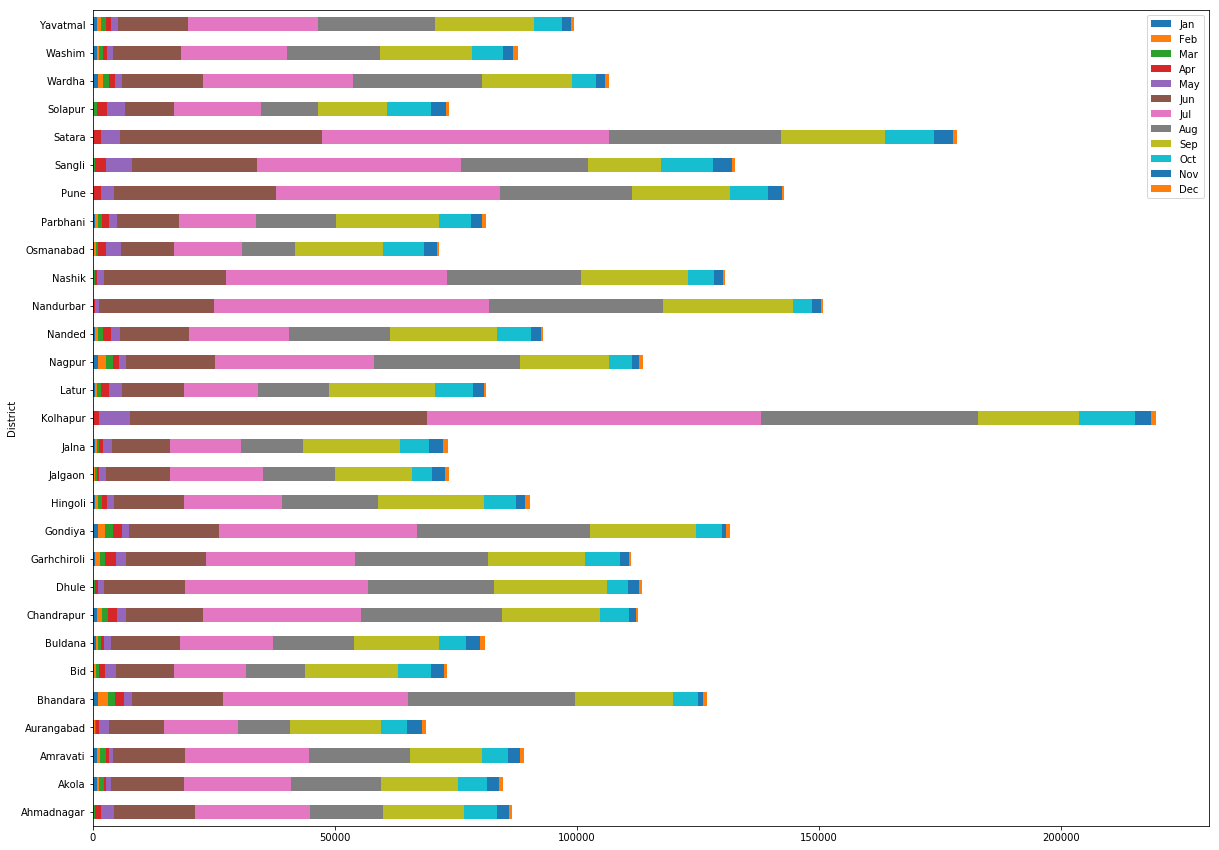

In [65]:
monthly_mean_data.plot.barh(stacked=True,figsize=(20,15));

## Annual rainfall in Maharshtra

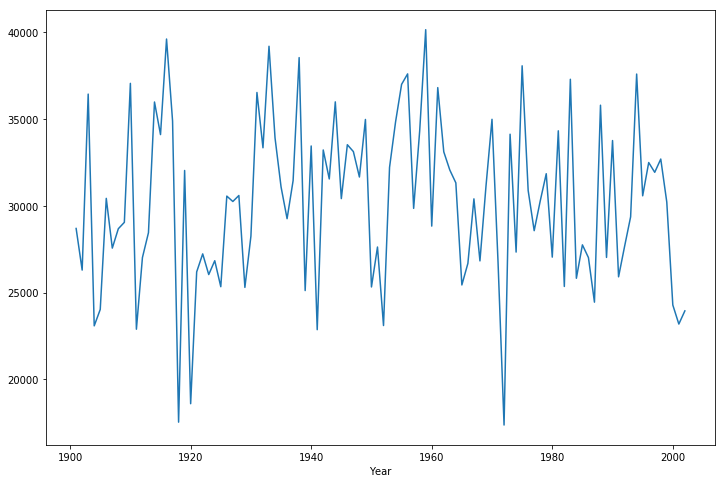

In [66]:
Annual_rainfall = m_data_copy.groupby('Year').sum()['Annual']
Annual_rainfall.plot(figsize=(12,8))

## Best method for each district

In [67]:
maharashtra_data.Ahmadnagar.head()

0     2.510
1    11.489
2    11.325
3    33.931
4    30.401
Name: Ahmadnagar, dtype: float64

In [68]:
dates

DatetimeIndex(['1901-01-01', '1901-02-01', '1901-03-01', '1901-04-01',
               '1901-05-01', '1901-06-01', '1901-07-01', '1901-08-01',
               '1901-09-01', '1901-10-01',
               ...
               '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01',
               '2002-07-01', '2002-08-01', '2002-09-01', '2002-10-01',
               '2002-11-01', '2002-12-01'],
              dtype='datetime64[ns]', length=1224, freq='MS')

In [69]:
rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data.Ahmadnagar[:-60]})
rainfall_data.index = dates[:-60]
rainfall_data.tail()

,Precipitation
1997-08-01,257.381
1997-09-01,45.384
1997-10-01,28.709
1997-11-01,85.942
1997-12-01,22.876


In [70]:
test_rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data.Ahmadnagar[-60:]})
test_rainfall_data.index = dates[-60:]
test_rainfall_data.head()

,Precipitation
1998-01-01,0.125
1998-02-01,2.136
1998-03-01,0.721
1998-04-01,0.365
1998-05-01,13.475


In [71]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(rainfall_data)

MinMaxScaler(copy=True, feature_range=(0, 1))

### FNN, TLNN, SANN and LSTM

In [98]:
future_steps = 60
STORAGE_FOLDER = 'State_predictions/'
if not os.path.exists(STORAGE_FOLDER):
    os.makedirs(STORAGE_FOLDER)

parameters_FNN = [[3,6,8,10,12], [4,5,6], [1], [300], [20], [future_steps]]
parameters_FNN = [[12], [4], [1], [50], [20], [future_steps]]

# time_lagged_points, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_TLNN = [[[1,2,3,11,12], [1,2,3,4,11,12], [1,2,3,4,5,6,10,11,12]], [3,4,5,6], [1], [300], [20], [future_steps]]
parameters_TLNN = [[[1,2,3,4,5,6,10,11,12]], [4], [1], [30], [20], [future_steps]]

# seasonal_period, hidden_nodes, epochs, batch_size, future_steps
parameters_SANN = [[12], [3,4,5,6], [300], [20], [future_steps]]
parameters_SANN = [[12], [3], [50], [20], [future_steps]]

# look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_LSTM = [[6,8,10,11,12], [4,5,6], [1], [300], [20], [future_steps]]
parameters_LSTM = [[12], [4], [1], [30], [20], [future_steps]]

Ahmadnagar
FNN - Number of combinations: 1
1
[14.977964732747525, 0.0, 0.0, 26.746078249651937, 73.02123691782356, 194.86790457376839, 187.231488114357, 184.00080791562795, 90.16548644655943, 58.58779220253229, 61.08101394106448, 27.521711415831, 16.424314369585364, 3.2282009373493494, 8.501227906126529, 40.314310829520224, 91.82252549122273, 158.87839088594913, 165.06713725709915, 153.7622517594099, 103.88705303302407, 72.53756011466682, 56.617642252385615, 31.869397899966685, 18.488799190741034, 10.021008301954716, 19.662958256382495, 50.83042694600672, 95.16331312555074, 138.31273333355784, 148.0512173936069, 138.0318869756162, 106.90524072474241, 79.02872628805041, 57.64757614961267, 35.95649101902917, 22.503276588071138, 17.830390238005666, 29.45742262686789, 57.60068646423519, 93.87980702219903, 125.04352608510851, 135.114308575809, 127.83068031051755, 106.01465543222427, 81.82852952744066, 59.83105641043186, 40.02676204228401, 27.66106002053991, 25.415372837830336, 37.3075860221

SANN - Number of combinations: 1
1
[-22.6839098765254, -42.951265263497824, -18.736530924856662, 39.585933691889046, 111.21536132764815, 172.42991223561762, 183.65393129873274, 158.54082490110397, 119.41907964956759, 75.86529910147189, 43.33565934258699, 8.072891144394873, -1.1983956568241119, 31.113270612597464, 78.87012658691405, 128.86821656942365, 163.3126440310478, 173.69107490205764, 147.44091193544864, 97.51947427082061, 46.109160423547024, 3.4365276280641552, -16.163385117530822, -18.11003024739027, -16.549705660045145, -16.1827728484869, 10.370441894888877, 52.49311246633529, 98.69850681602954, 139.00611647987364, 155.8938764646053, 149.67473552203177, 127.4511026880741, 85.28320638740063, 42.517727902561425, 4.270101581811905, 6.598291102051735, 42.01739826977253, 84.94550288832187, 123.82782504963873, 146.0784406812191, 149.24965798211096, 130.22863210868834, 94.75896296960114, 56.4431072229743, 18.186565623402593, -4.96612112313509, -10.222141140162943, -4.413078404068947, 

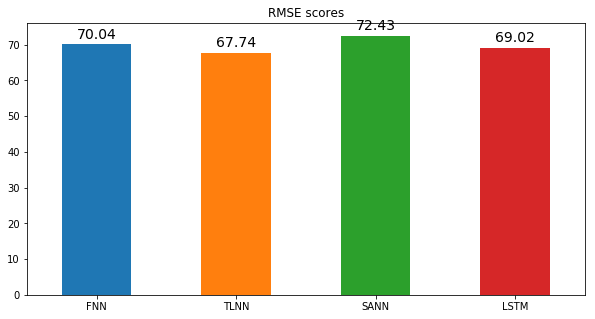

In [99]:
for district in districts[:2]:
    print(district)
    
    rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data[district][:-60]})
    rainfall_data.index = dates[:-60]
    
    test_rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data[district][-60:]})
    test_rainfall_data.index = dates[-60:]
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(rainfall_data)
    
    output_folder = STORAGE_FOLDER + district + '/'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    ANN = reload(ANN)
    RMSE_info, MAE_info, R_info = ANN.compare_ANN_methods(rainfall_data, test_rainfall_data, scaler, 
                    parameters_FNN, parameters_TLNN, parameters_SANN, parameters_LSTM, future_steps, output_folder)

    ANN = reload(ANN)
    ANN.save_RMSE_info(output_folder, RMSE_info, MAE_info, R_info)

In [100]:
districts

Index(['Ahmadnagar', 'Akola', 'Amravati', 'Aurangabad', 'Bhandara', 'Bid',
       'Buldana', 'Chandrapur', 'Dhule', 'Garhchiroli', 'Gondiya', 'Hingoli',
       'Jalgaon', 'Jalna', 'Kolhapur', 'Latur', 'Nagpur', 'Nanded',
       'Nandurbar', 'Nashik', 'Osmanabad', 'Parbhani', 'Pune', 'Sangli',
       'Satara', 'Solapur', 'Wardha', 'Washim', 'Yavatmal'],
      dtype='object')

### Update with ARIMA and find the best method

Ahmadnagar
State_predictions/Ahmadnagar/
(0, 0, 0)
14467.767233685541
13900.091340245079
13283.289131426285
12567.89255140194
13309.66904591173
12716.833973756326
13034.625454645677
12569.270568278065
(0, 0, 1)
14033.067456125114
13686.698502517074
13284.489759186086
12569.1307945138
13297.826714842715
12718.773911490984
13036.449794371554
12570.521160994298
(0, 1, 0)
13973.325711964859
13830.974705333932
14039.250733973833
13325.317895770579
13773.869865210627
13461.60605959124
13807.322904075041
13326.8528822002
(0, 1, 1)
13901.81713346814
13664.861759082733
13281.881116529794
12572.641519642715
13228.721245388928
13034.043529626684
12574.198723672962
(1, 0, 0)
13777.005765861788
13556.134734475034
13284.462070450623
12569.09270623373
13294.734433386435
12718.115808438277
13036.444560181324
12570.4813857236
(1, 0, 1)
13771.728037032699
13536.298647468153
13286.400984596077
12569.776253749103
13283.370734978918
12736.375453600014
13038.288683775856
12571.443992353565
(1, 1, 0)
13905.9

FileNotFoundError: [Errno 2] No such file or directory: 'State_predictions/Ahmadnagar/BEST_FORECAST_LSTM.png'

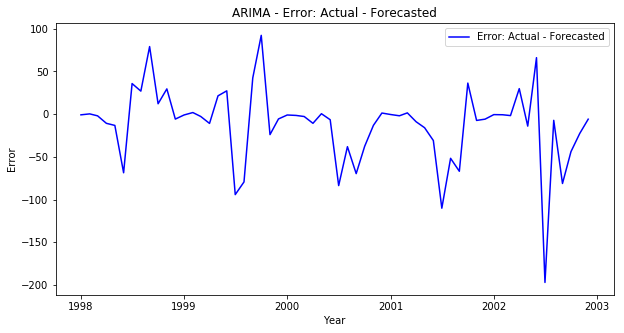

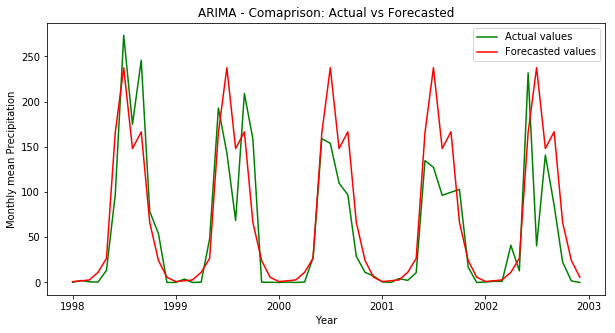

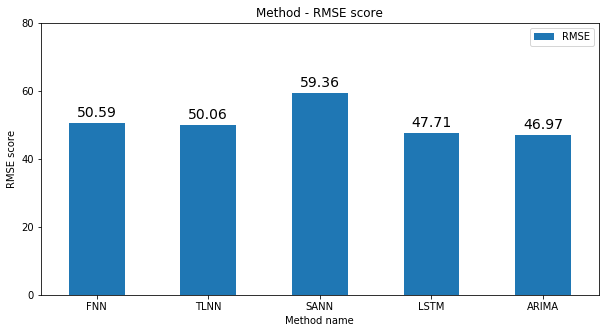

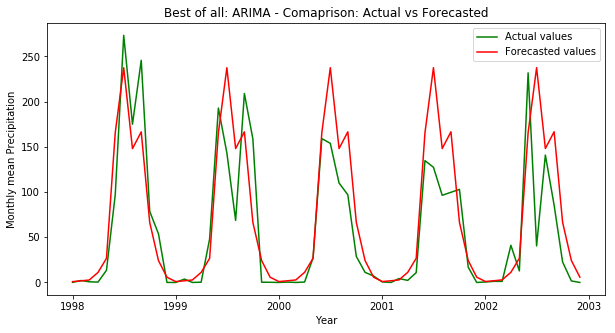

In [102]:
for district in districts[:2]:
    print(district)
    
    rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data[district][:-60]})
    rainfall_data.index = dates[:-60]
    
    test_rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data[district][-60:]})
    test_rainfall_data.index = dates[-60:]
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(rainfall_data)
    
    output_folder = STORAGE_FOLDER + district + '/'
    print(output_folder)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    ARIMA = reload(ARIMA)
    forecasted_values = ARIMA.ARIMA(rainfall_data, output_folder, future_steps)
    
    errors = test_rainfall_data.Precipitation - forecasted_values
    ARIMA_actual_forecasted = pd.DataFrame({'Actual': test_rainfall_data.Precipitation, 
                                           'Forecasted': forecasted_values,
                                           'Errors': errors})
    ARIMA_actual_forecasted.to_csv(output_folder + '/' + 'ARIMA_actual_and_forecasted.csv')
    
    plt.figure(figsize=(10,5))
    plt.plot(ARIMA_actual_forecasted.drop(columns=['Actual', 'Forecasted']), color='blue', label='Error: Actual - Forecasted')
    plt.xlabel('Year')
    plt.ylabel('Error')
    plt.legend(loc='best')
    plt.title('ARIMA - Error: Actual - Forecasted')
    plt.savefig(output_folder + 'ARIMA_error_plot'  + '.png')
    
    y_true = test_rainfall_data.ix[:int(future_steps)]
    plt.figure(figsize=(10,5))
    plt.plot(y_true, color='green', label='Actual values')
    plt.plot(forecasted_values, color='red', label='Forecasted values')
    plt.xlabel('Year')
    plt.ylabel('Monthly mean Precipitation')
    plt.legend(loc='best')
    plt.title('ARIMA - Comaprison: Actual vs Forecasted')
    plt.savefig(output_folder + 'ARIMA_best_forecast'  + '.png')
    
    mse, mae, mape, rmse, corr_coef = calculate_performance(y_true, list(forecasted_values))
    
    RMSE_score = pd.read_csv(output_folder + 'RMSE_score.csv')
    max_score = RMSE_score.RMSE.max()
    best_method = RMSE_score.iloc[RMSE_score.RMSE.argmin]['Unnamed: 0']
    RMSE_score = RMSE_score.append({'Unnamed: 0': 'ARIMA', 'RMSE': str(rmse), 'MAE': str(mae), 'R': str(corr_coef)}, ignore_index=True)
    RMSE_score.RMSE = RMSE_score.RMSE.astype('float')
    
    current_best_method = RMSE_score.iloc[RMSE_score.RMSE.argmin]['Unnamed: 0']
    
    RMSE_score = RMSE_score.set_index('Unnamed: 0')
    RMSE_score.to_csv(output_folder + 'RMSE_score.csv')
    
    axis = RMSE_score.plot(kind='bar', figsize=(10,5), rot=0, title='RMSE scores')
    axis.set_xlabel('Method name')
    axis.set_ylabel('RMSE score')
    axis.set_title('Method - RMSE score')
    
    max_score = int(((max_score / 10)*10)+30)
    yticks = [x for x in list(range(max_score+1)) if x%20 == 0]
    axis.set_yticks(yticks)
    
    for p in axis.patches:
        axis.annotate(np.round(p.get_height(),decimals=2), 
                    (p.get_x()+p.get_width()/2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 10), 
                    textcoords='offset points', fontsize=14, color='black')
    
    fig = axis.get_figure()
    fig.savefig(output_folder + 'RMSE.png')
    
    if current_best_method == 'ARIMA':
        y_true = test_rainfall_data.ix[:int(future_steps)]
        plt.figure(figsize=(10,5))
        plt.plot(y_true, color='green', label='Actual values')
        plt.plot(forecasted_values, color='red', label='Forecasted values')
        plt.xlabel('Year')
        plt.ylabel('Monthly mean Precipitation')
        plt.legend(loc='best')
        plt.title('Best of all: ARIMA - Comaprison: Actual vs Forecasted')
        plt.savefig(output_folder + 'BEST_FORECAST_ARIMA'  + '.png')
        print('abhi')
        os.remove(output_folder + 'BEST_FORECAST_' + best_method + '.png')

### Put all best forecast prediction files in a folder

In [ ]:
STORAGE_FOLDER = 'State_predictions/'
# OUTPUT_FOLDER = 'Best_forecast_predictions/'
if not os.path.exists(OUTPUT_FOLDER):
        os.makedirs(OUTPUT_FOLDER)

for district in districts:
    file = STORAGE_FOLDER + district + '/' + 'RMSE_score.csv'
    rmse_score = pd.read_csv(file)
    method = rmse_score.ix[rmse_score.RMSE.argmin]['Unnamed: 0']
    shutil.copy(STORAGE_FOLDER + district + '/' + 'BEST_FORECAST_' + method + '.png', OUTPUT_FOLDER)
    os.rename(OUTPUT_FOLDER + 'BEST_FORECAST_' + method + '.png',
             OUTPUT_FOLDER + '/' + district + '_' + method + '.png')

### Put all best forecast prediction files in a folder

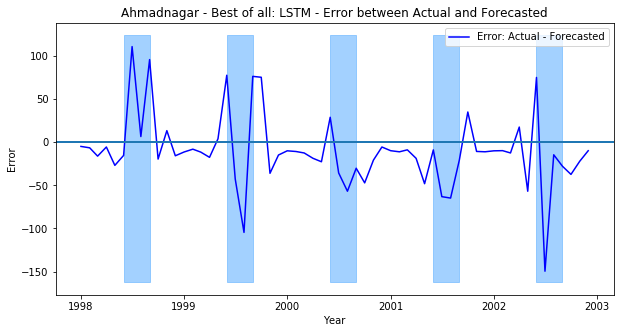

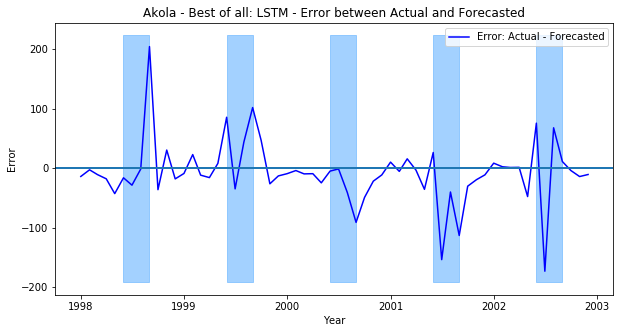

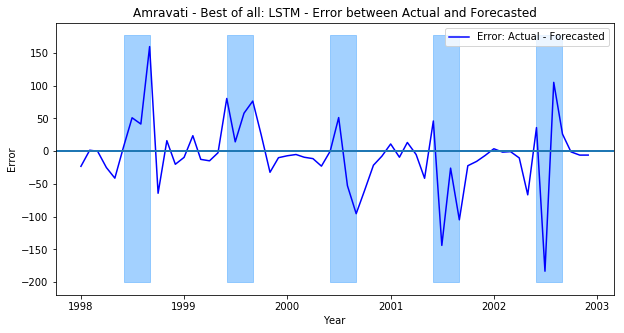

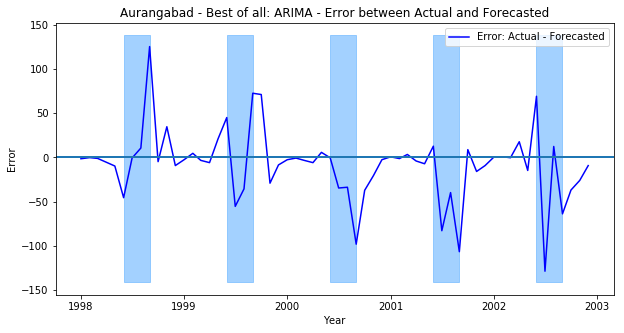

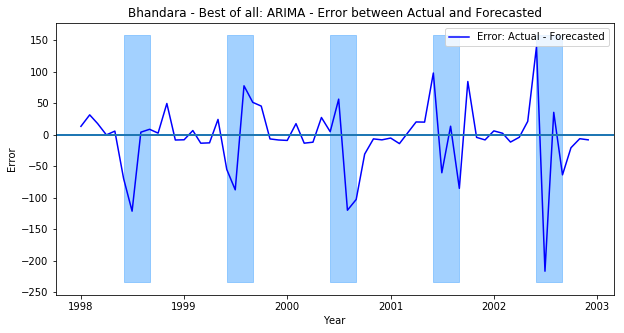

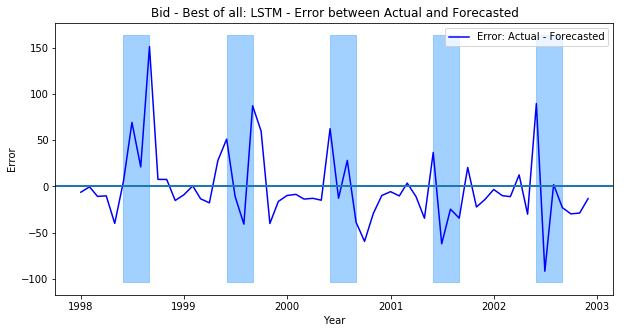

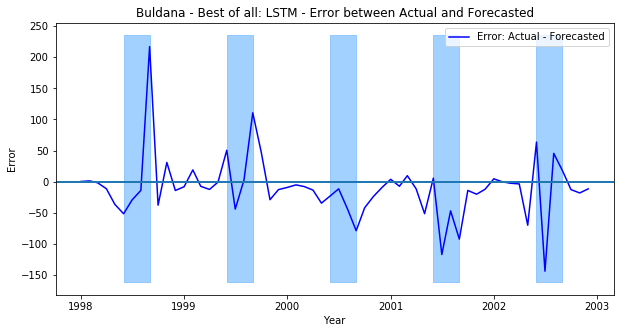

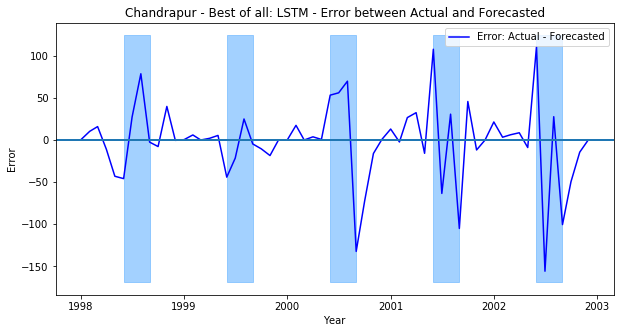

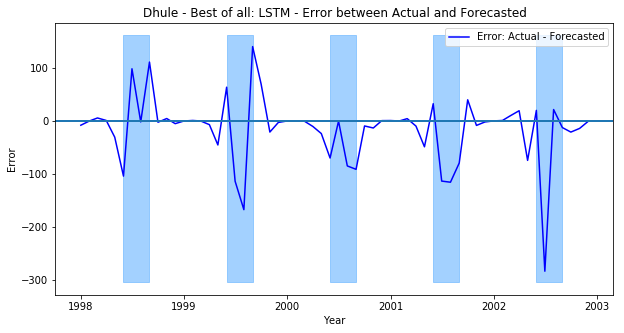

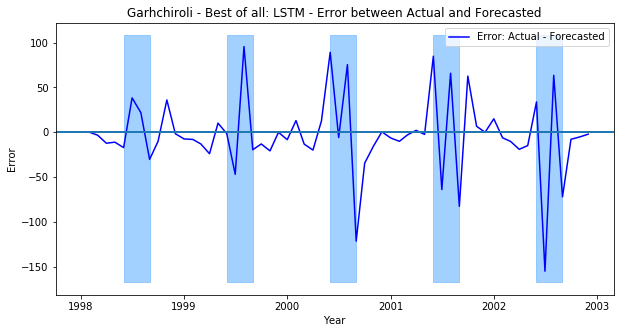

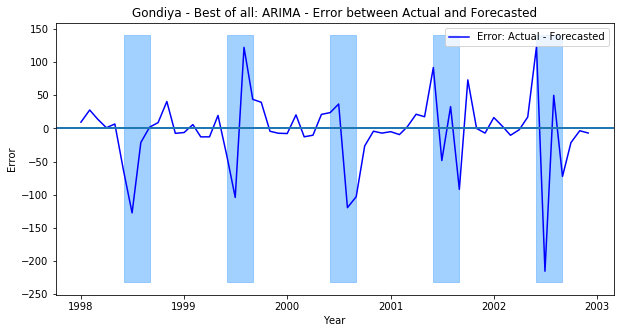

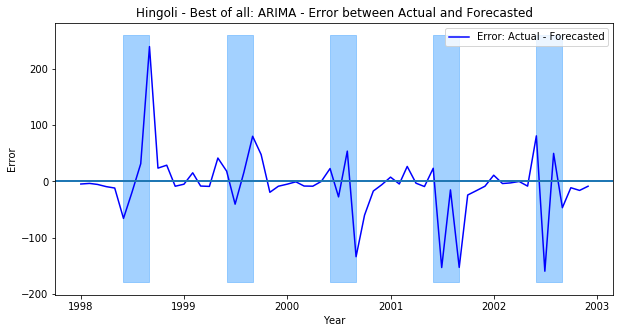

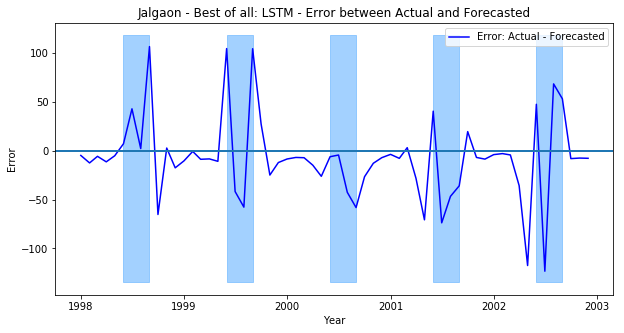

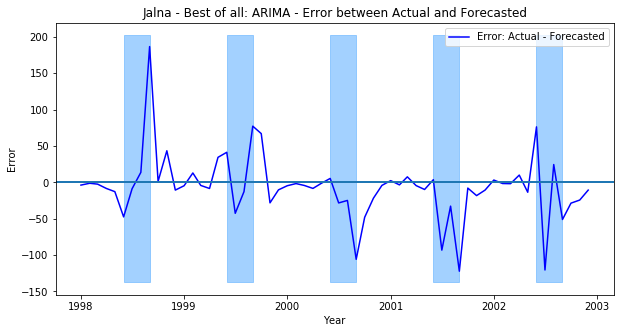

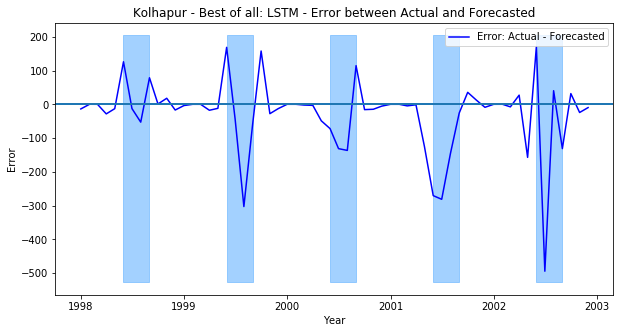

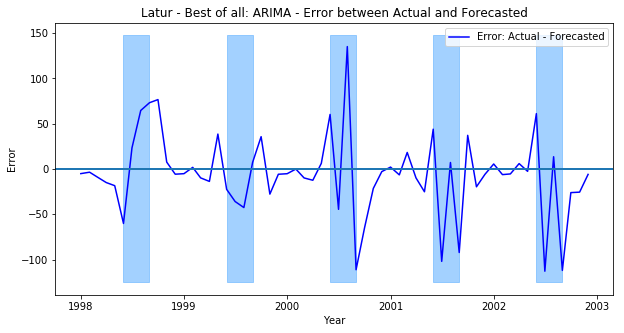

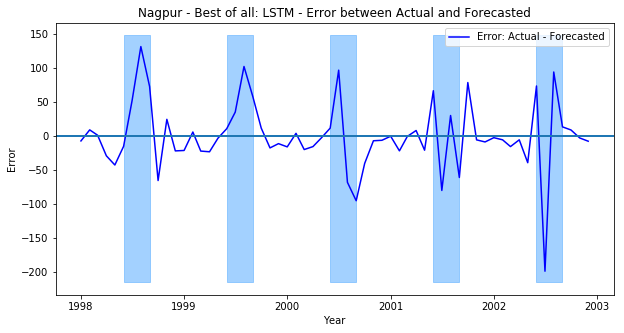

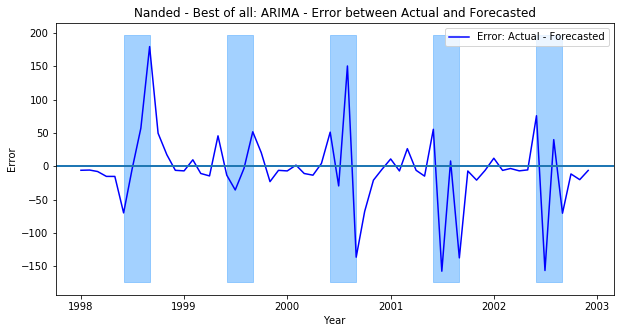

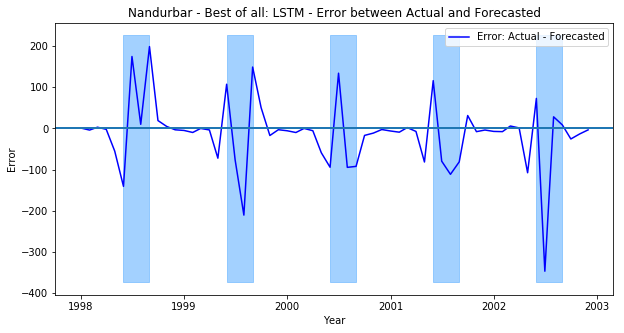

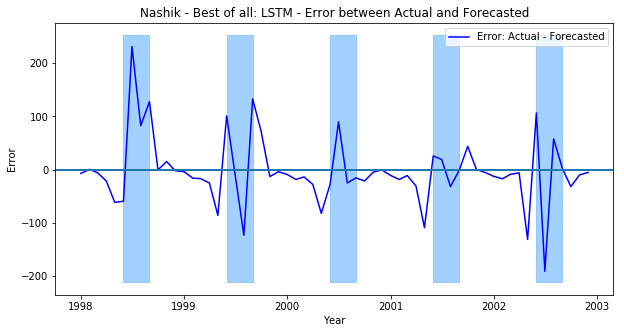

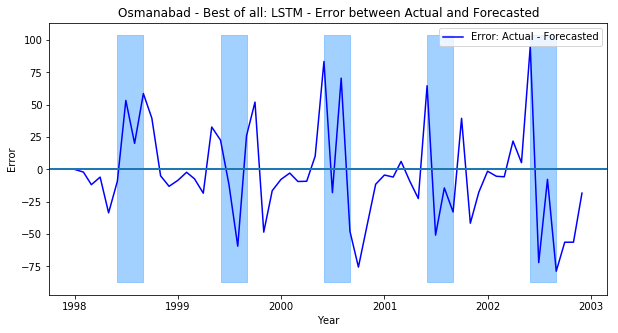

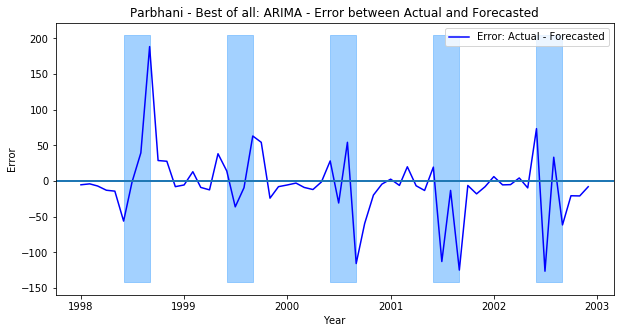

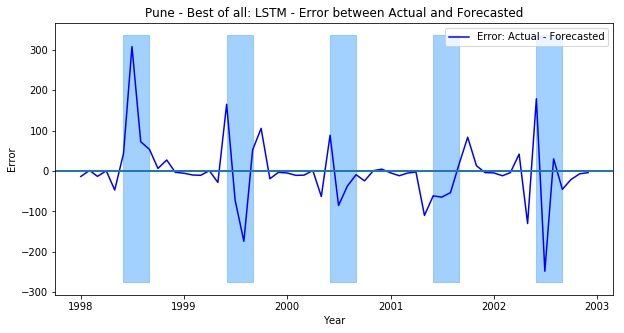

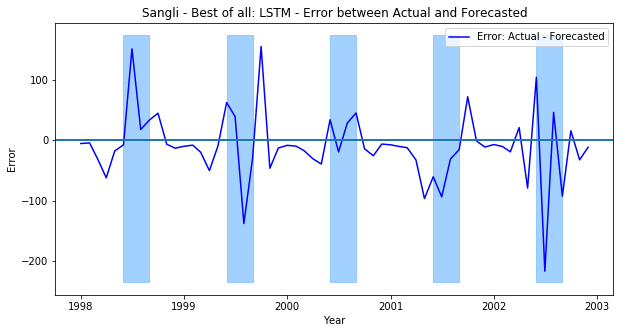

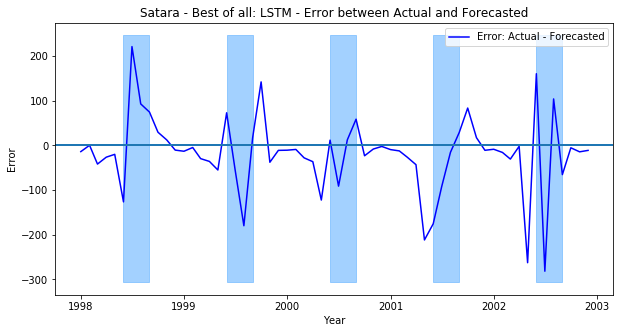

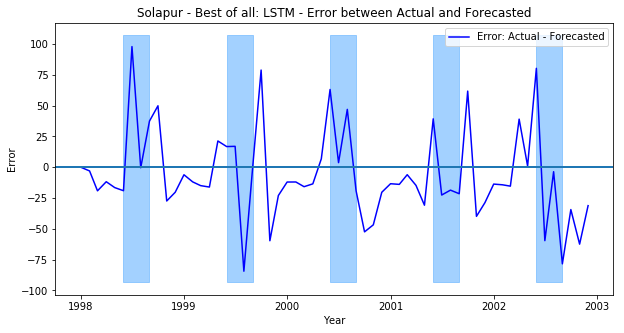

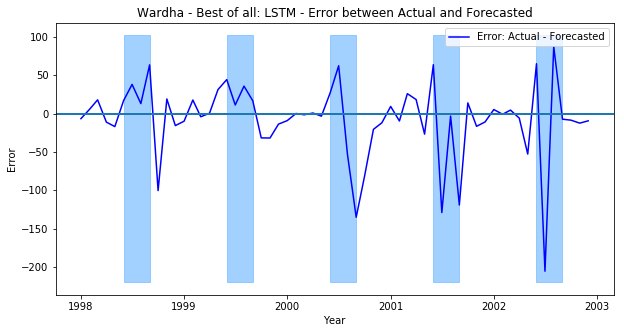

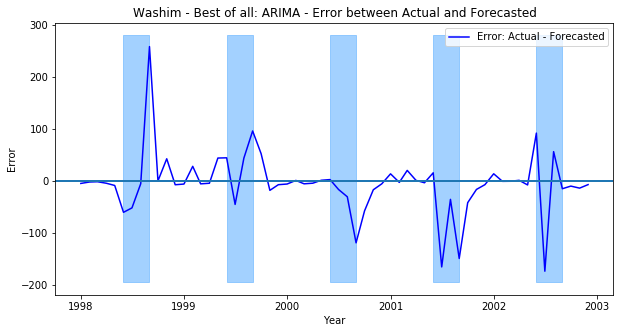

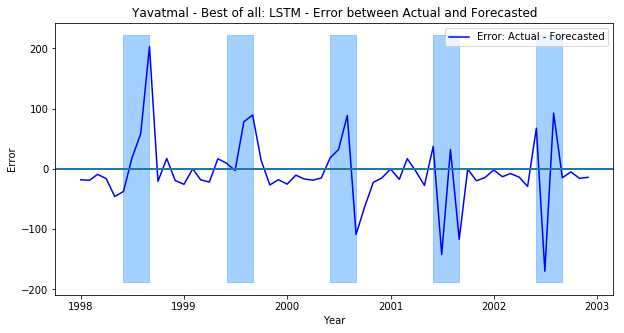

In [145]:
STORAGE_FOLDER = 'State_predictions/'
OUTPUT_FOLDER = 'Best_forecast_predictions/'
if not os.path.exists(OUTPUT_FOLDER):
        os.makedirs(OUTPUT_FOLDER)
OUTPUT_FOLDER_ERRORS = 'Best_forecast_errors'
if not os.path.exists(OUTPUT_FOLDER_ERRORS):
        os.makedirs(OUTPUT_FOLDER_ERRORS)

for district in districts:
    file = STORAGE_FOLDER + district + '/' + 'RMSE_score.csv'
    rmse_score = pd.read_csv(file)
    method = rmse_score.ix[rmse_score.RMSE.argmin]['Unnamed: 0']
    
    actual_forecast = pd.read_csv(STORAGE_FOLDER + district + '/' + method + '_actual_and_forecasted.csv')
    actual_forecast.rename(columns={'Unnamed: 0': 'Year'}, inplace=True)
    actual_forecast.Year = pd.to_datetime(actual_forecast['Year'])
    actual_forecast = actual_forecast.set_index('Year')
    y_true = actual_forecast.drop(columns=['Errors', 'Forecasted'])
    forecast_values = actual_forecast.drop(columns=['Actual', 'Errors'])
    errors = actual_forecast.drop(columns=['Actual', 'Forecasted'])
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, frame_on=True)
    plt.plot(errors, color='blue', label='Error: Actual - Forecasted')
    plt.xlabel('Year')
    plt.ylabel('Error')
    plt.legend(loc='best')
    plt.axhline(y=0, linewidth=2, linestyle=None)
    plt.title(district + ' - Best of all: ' + method + ' - Error between Actual and Forecasted')
    
    ylim = ax.get_ylim()
    for year in ['1998', '1999', '2000', '2001', '2002']:
        ax.fill_betweenx(ylim, pd.to_datetime(year + '-06-01'), pd.to_datetime(year + '-09-01'), 
                         alpha=0.6, zorder=-1, color='#66b3ff')
    plt.savefig(OUTPUT_FOLDER_ERRORS + '/' + district + '_' + method + '.png')

### Create a table - Districts, Method, RMSE

In [64]:
STORAGE_FOLDER = 'State_predictions/'
district_method_RMSE = []
columns = ['District', 'FNN', 'TLNN', 'SANN', 'LSTM', 'ARIMA', 'Best method', 'Min RMSE']
l = []
for district in districts:
    l = [district]
    file = STORAGE_FOLDER + district + '/' + 'RMSE_score.csv'
    rmse_score = pd.read_csv(file)
    method = rmse_score.ix[rmse_score.RMSE.argmin]['Unnamed: 0']
    min_RMSE = rmse_score.RMSE.min()
    l = l + list(rmse_score.RMSE) + [method, min_RMSE]
    district_method_RMSE.append(l)

district_method_RMSE = pd.DataFrame(district_method_RMSE)
district_method_RMSE.columns = columns
district_method_RMSE.to_csv('district_method_RMSE.csv')
district_method_RMSE

,District,FNN,TLNN,SANN,LSTM,ARIMA,Best method,Min RMSE
0,Ahmadnagar,47.758,49.099,59.038,43.626,46.970,LSTM,43.626
1,Akola,69.053,66.114,71.408,53.474,55.675,LSTM,53.474
2,Amravati,66.672,66.035,71.407,52.285,54.556,LSTM,52.285
3,Aurangabad,49.483,49.096,56.251,41.451,40.869,ARIMA,40.869
4,Bhandara,74.764,71.052,88.694,55.105,54.675,ARIMA,54.675
5,Bid,49.097,49.271,56.658,38.846,39.095,LSTM,38.846
6,Buldana,63.314,62.714,67.108,49.908,50.733,LSTM,49.908
7,Chandrapur,65.068,61.047,84.626,47.171,49.873,LSTM,47.171
8,Dhule,64.983,65.965,86.818,64.913,78.134,LSTM,64.913
9,Garhchiroli,63.512,61.494,77.557,43.009,48.285,LSTM,43.009


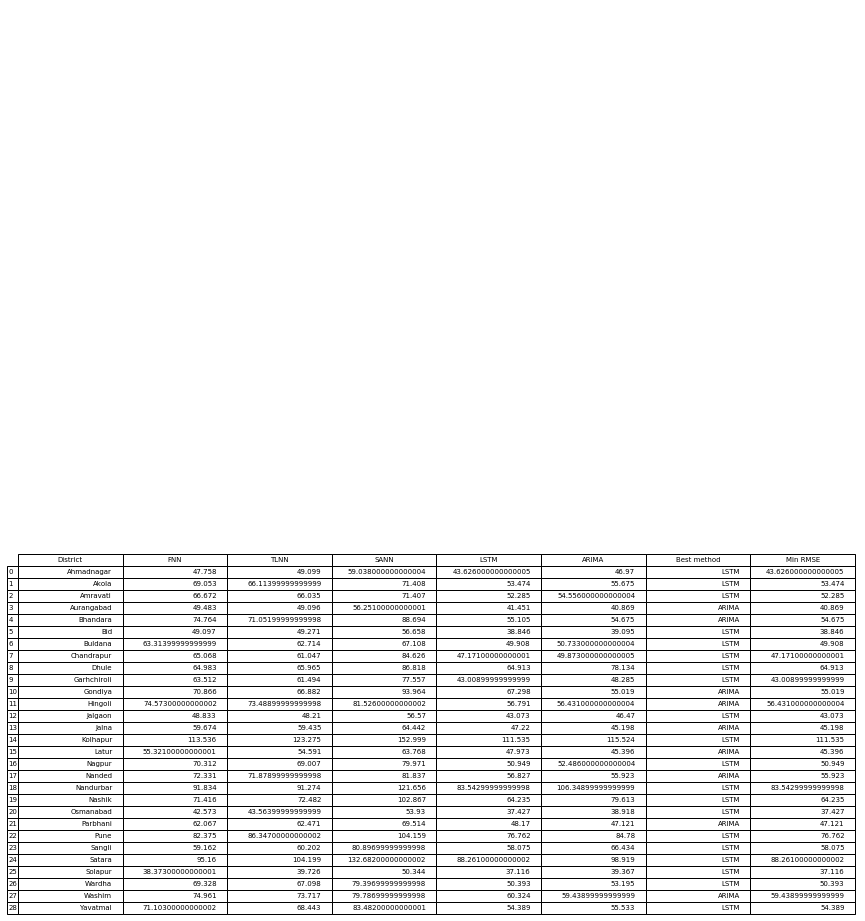

In [72]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tools.plotting import table

plt.figure(figsize=(15,10))
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

table(ax, district_method_RMSE)

plt.savefig('district_method_RMSE.png')

### Make video - Actual vs forecasted maps for forecasted years

In [141]:
import cv2
import os

image_folder = 'Actual_vs_Forecasted_Plots'
video_name = 'Actual_vs_Forecasted_Visulization.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images = sorted(images)
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'MP42')
video = cv2.VideoWriter(video_name, fourcc, float(0.5), (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

### Maharashtra Map - Visualization

In [ ]:
year_precipation = pd.DataFrame({'Precipitation': maharashtra_data.ix[0][3:]})
year_precipation.index = maharashtra_data.ix[0].index[3:]
year_precipation.head()

In [ ]:
num_colors = 9
values = year_precipation['Precipitation'].astype(float)
cm = plt.get_cmap('rainbow')
# rainbow, spring, PuRd, plasma
scheme = [cm(i / num_colors) for i in range(num_colors)]
bins = np.linspace(values.min(), values.max(), num_colors)
year_precipation['bin'] = np.array(np.digitize(values, bins) - 1)
year_precipation.sort_values('bin', ascending=False).head()

In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, frame_on=False)

map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
               llcrnrlat=15,urcrnrlon=82,urcrnrlat=22,lat_0=16,lon_0=75.11)

map.drawmapboundary(fill_color='white')
map.fillcontinents(color='white',lake_color='white')
# map.drawcoastlines()

map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)

patches   = []
facecolor_array = []

for info, shape in zip(map.gadm36_IND_2_info, map.gadm36_IND_2):
    if(info['NAME_1'] == 'Maharashtra'):
        x, y = zip(*shape) 
        map.plot(x, y, marker=None, color='black')
        
        district = info['NAME_2']
        if district not in year_precipation.index:
            color = '#dddddd'
        else:
            color = scheme[year_precipation.ix[district]['bin']]
            patches.append( Polygon(np.array(shape), True))
            facecolor_array.append(color)
    else:
        color = '#dddddd'

ax.add_collection(PatchCollection(patches, facecolor= facecolor_array, edgecolor='w', linewidths=1., zorder=2))
    
#ax.axhspan(0, 1000 * 1800, facecolor=facecolor_array, edgecolor='w', zorder=2)
ax_legend = fig.add_axes([0.45, 0.20, 0.3, 0.03], zorder=3)
cmap = matplotlib.colors.ListedColormap(scheme)
cb = matplotlib.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

plt.show()

In [ ]:
latlon_data = pd.read_csv("district_latlon.csv") 
latlon_data = latlon_data.drop(latlon_data.columns[latlon_data.columns.str.contains('unnamed',case = False)],axis = 1)
latlon_data.shape

In [ ]:
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111, frame_on=False)

map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
               llcrnrlat=15,urcrnrlon=82,urcrnrlat=22,lat_0=16,lon_0=75.11)

map.drawmapboundary(fill_color='white')
map.fillcontinents(color='white',lake_color='white')
# map.drawcoastlines()

map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)

patches   = []
facecolor_array = []

for info, shape in zip(map.gadm36_IND_2_info, map.gadm36_IND_2):
    if(info['NAME_1'] == 'Maharashtra'):
        x, y = zip(*shape) 
        map.plot(x, y, marker=None, color='w')

        district = info['NAME_2']
        if district not in year_precipation.index:
            color = '#dddddd'
        else:
            color = scheme[year_precipation.ix[district]['bin']]
            patches.append( Polygon(np.array(shape), True))
            facecolor_array.append(color)
    else:
        color = '#dddddd'

ax.add_collection(PatchCollection(patches, facecolor= facecolor_array, edgecolor='w', linewidths=1., zorder=2))
ax.set_title("Maharashtra Map")    

lat = latlon_data['lat'].tolist()
lon = latlon_data['lon'].tolist()
label_dist = latlon_data['district'].tolist()

X,Y = map(lon,lat)
ax.scatter(X,Y)
for i, (x, y) in enumerate(zip(X, Y), start=0):
    ax.annotate(label_dist[i], (x,y), xytext=(0,0), textcoords='offset points',fontsize=12,color='black',arrowprops=dict(facecolor='white', shrink=0.1))

#ax.axhspan(0, 1000 * 1800, facecolor=facecolor_array, edgecolor='w', zorder=2)
ax_legend = fig.add_axes([0.45, 0.20, 0.3, 0.03], zorder=3)
cmap = matplotlib.colors.ListedColormap(scheme)
cb = matplotlib.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

plt.show()

In [ ]:
STORAGE_FOLDER = 'State_predictions/'
district_best_method = {}
for district in districts:
    file = STORAGE_FOLDER + district + '/' + 'RMSE_score.csv'
    rmse_score = pd.read_csv(file)
    method = rmse_score.ix[rmse_score.RMSE.argmin]['Unnamed: 0']
    district_best_method[district] = method

In [ ]:
latlon_data = pd.read_csv("district_latlon.csv") 
latlon_data = latlon_data.drop(latlon_data.columns[latlon_data.columns.str.contains('unnamed',case = False)],axis = 1)
latlon_data.shape

In [ ]:
latlon_data = pd.read_csv("district_latlon.csv") 
latlon_data = latlon_data.drop(latlon_data.columns[latlon_data.columns.str.contains('unnamed',case = False)],axis = 1)

num_colors = 2
cm = plt.get_cmap('rainbow')
best_method_df = pd.DataFrame({'Method': list(district_best_method.values())})
best_method_df.index = district_best_method.keys()
best_method_df['bin'] = best_method_df.Method.map({'ARIMA': 0, 'LSTM': 1})
scheme = ['#ff99cc', '#cc99ff']

values = best_method_df.bin
bins = np.linspace(values.min(), values.max(), num_colors)



fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111, frame_on=False)

# map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
#                llcrnrlat=15,urcrnrlon=82,urcrnrlat=22,lat_0=16,lon_0=75.11)

map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
               llcrnrlat=15.5,urcrnrlon=82,urcrnrlat=22.5,lat_0=16,lon_0=75.11)

map.drawmapboundary(fill_color='white')
map.fillcontinents(color='white',lake_color='white')

map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)

patches   = []
facecolor_array = []

for info, shape in zip(map.gadm36_IND_2_info, map.gadm36_IND_2):
    if(info['NAME_1'] == 'Maharashtra'):
        x, y = zip(*shape) 
        map.plot(x, y, marker=None, color='w')

        district = info['NAME_2']
        if district not in best_method_df.index:
            color = '#dddddd'
        else:
            color = scheme[best_method_df.ix[district]['bin']]
            patches.append( Polygon(np.array(shape), True))
            facecolor_array.append(color)
    else:
        color = '#dddddd'

ax.add_collection(PatchCollection(patches, facecolor= facecolor_array, edgecolor='w', linewidths=1., zorder=2))
ax.set_title("District wise best method")

lat = latlon_data['lat'].tolist()
lon = latlon_data['lon'].tolist()
label_dist = latlon_data['district'].tolist()

X,Y = map(lon,lat)
ax.scatter(X,Y)
for i, (x, y) in enumerate(zip(X, Y), start=0):
    district_name = label_dist[i]
    ax.annotate(district_name + '\n' + district_best_method[district_name], (x,y), xytext=(0,0), textcoords='offset points',fontsize=12,color='black')

patch1 = mpatches.Patch(color=scheme[0], label='ARIMA')
patch2 = mpatches.Patch(color=scheme[1], label='LSTM')
plt.legend(handles=[patch1, patch2])

plt.show()

In [17]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    smape = 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    return smape

In [26]:
dummy_df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 8]})
dummy_df

,A,B
0,1,4
1,2,5
2,3,8


In [31]:
def correlation_coefficient(y_true, y_pred):
    corr_coef = np.corrcoef(y_true, y_pred)[0, 1]
    return corr_coef

In [32]:
correlation_coefficient(dummy_df.A, dummy_df.B)

0.9607689228305228